In [34]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x +5

In [4]:
f(3.0)

20.0

In [61]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other):        
        return  self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward        
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support integer and float value for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward
        return out        

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**(-1)

    def __neg__(self):
        return self * (-1)

    def __sub__(self, other):
        return self + (-other)
        
    def __rsub__(self, other):
        return -(other + (-self))

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward       
        return out
    
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1
        for node in reversed(topo):
            node._backward()        


In [62]:
a = Value(1.0)
b = Value(4.0)
- b

Value(data=-4.0)

In [63]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s| data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

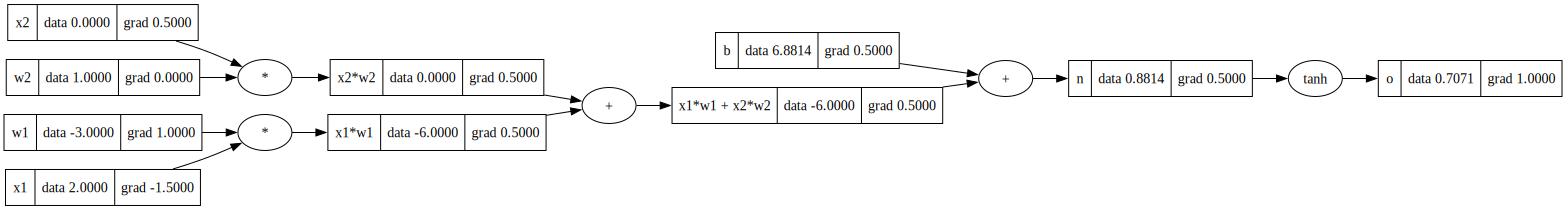

In [64]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

In [65]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# ----------------
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = 'o'

o.backward()


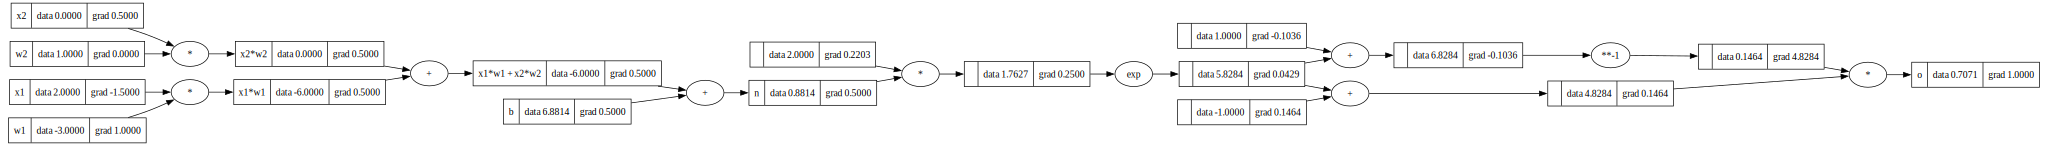

In [66]:
draw_dot(o)

In [67]:
import torch

In [68]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [312]:
class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def  __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
  
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
      
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0
      


In [321]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

In [322]:
for k in range(50):
    # forward
    ypred = [n(x) for x in xs]
    loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    n.zero_grad()
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad    
    
    print(k, loss.data)

0 4.391231565445336
1 2.620586308103729
2 1.5815374034874181
3 0.8908918046633583
4 0.5238233939035473
5 0.33754673903152277
6 0.23738298143943984
7 0.1784524969631427
8 0.14090105159510607
9 0.11536565412422449
10 0.09708766333525529
11 0.08346294007934366
12 0.07297136966021672
13 0.06467594507321532
14 0.05797207509783826
15 0.05245432923030183
16 0.047841782555189144
17 0.04393424060647344
18 0.04058553539090332
19 0.03768666348767123
20 0.03515481172245147
21 0.032926021407916686
22 0.03095016715839989
23 0.029187446480645897
24 0.027605878517378404
25 0.026179491039736484
26 0.02488698574603293
27 0.02371074169756275
28 0.022636061557707213
29 0.021650594687472224
30 0.02074389076452905
31 0.019907050904127564
32 0.019132452434251275
33 0.01841352989063371
34 0.0177445993401397
35 0.01712071639876176
36 0.016537560673538978
37 0.015991341090216847
38 0.015478717851467278
39 0.014996737729578595
40 0.014542780120836537
41 0.014114511838878036
42 0.013709849045892968
43 0.013326925

In [323]:
ypred

[Value(data=0.961698604225488),
 Value(data=-0.9631280344591582),
 Value(data=-0.9421951063507049),
 Value(data=0.9276491317786928)]